### 각 모델 별 특정 클래스/특정 크기의 bbox를 예측하는 특성이 있는지, submission.csv의 분포를 통해 확인해보자.

# 01. YOLO v6
```python
# inference setting
confidence_threshold : 0.4
iou_threshold : 0.45
```

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


def category_distribution(path):
    preds = pd.read_csv(path)

    category_distribution = [0 for _ in range(10)]
    no_object_cnt = 0

    for pred in preds['PredictionString']:
        try:
            splitted_preds = pred.split()
        except:
            no_object_cnt += 1
            continue
    
        for idx in range(0, len(splitted_preds), 6):
            category_id = int(splitted_preds[idx])
            confidence_score = float(splitted_preds[idx+1])

            category_distribution[category_id] += 1
                
    print('테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포')
    print(category_distribution, 'total : ', sum(category_distribution))
    print(no_object_cnt)

    total_boxes = sum(category_distribution)
    ratios = [x / total_boxes for x in category_distribution]
    labels = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

    plt.pie(ratios, labels=labels, autopct="%.1f%%")
    plt.show()


def show_bbox_distribution(path):
    # csv load
    model_preds = pd.read_csv(path)

    bbox_areas = [0 for _ in range(3)] # small, medium, large

    no_object_cnt = 0
    for preds in model_preds['PredictionString']:
        try:
            splitted_preds = preds.split()
        except:
            no_object_cnt += 1
            continue

        for idx in range(0, len(splitted_preds), 6):
            category_id = int(splitted_preds[idx])
            confidence_score = float(splitted_preds[idx+1])
            x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

            bbox_area = (x_max - x_min) * (y_max - y_min) # widht * height = bbox area

            if bbox_area < 32**2: # small bbox
                bbox_areas[0] += 1
            elif bbox_area > 32**2 and bbox_area < 96**2:
                bbox_areas[1] += 1
            elif bbox_area > 96**2:
                bbox_areas[2] += 1

    total_bboxes = sum(bbox_areas)
    areas_ratio = [x / total_bboxes for x in bbox_areas]

    plt.pie(areas_ratio, labels=['small', 'medium', 'large'], autopct="%.1f%%")
    plt.show()

In [4]:
# csv load

universenet_preds = pd.read_csv("/opt/ml/YOLOv6/submission/2023-5-16/yolov6l6_high_th.csv")

category_distribution = [0 for _ in range(10)]

no_object_cnt = 0
for preds in universenet_preds['PredictionString']:
    try:
        splitted_preds = preds.split()
    except:
        no_object_cnt += 1
        continue
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])

        category_distribution[category_id] += 1
        
        
print('테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포')
print(category_distribution, 'total : ', sum(category_distribution))
print(no_object_cnt)

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[2334, 5378, 894, 819, 1177, 2574, 1187, 4680, 155, 425] total :  19623
32


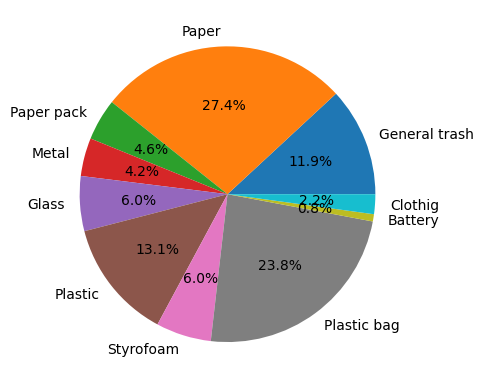

In [7]:
import matplotlib.pyplot as plt

total_boxes = sum(category_distribution)
ratios = [x / total_boxes for x in category_distribution]
labels = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothig']

plt.pie(ratios, labels=labels, autopct="%.1f%%")
plt.show()

- COCO 데이터셋에서는 bbox의 크기를 small, medium, large로 나누는데, 그 기준은 다음과 같다.
    - small : 32^2 이하의 bbox 면적
    - medium : 32^2 ~ 96^2 사이의 bbox 면적
    - larget : 96^2 이상의 bbox 면적

- 재활용쓰레기 데이터의 경우, 1024^1024이니깐 small과 medium box가 작아도 너무 작다..
- 일단은 COCO 기준으로 모델이 예측한 bbox의 small, medium, large 분포를 확인해보자.

In [8]:
# csv load
import pandas as pd

universenet_preds = pd.read_csv("/opt/ml/YOLOv6/submission/2023-5-16/yolov6l6_high_th.csv")

bbox_areas = [0 for _ in range(3)] # small, medium, large

no_object_cnt = 0
for preds in universenet_preds['PredictionString']:
    try:
        splitted_preds = preds.split()
    except:
        no_object_cnt += 1
        continue
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])
        x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

        bbox_area = (x_max - x_min) * (y_max - y_min) # widht * height = bbox area

        if bbox_area < 32**2: # small bbox
            bbox_areas[0] += 1
        elif bbox_area > 32**2 and bbox_area < 96**2:
            bbox_areas[1] += 1
        elif bbox_area > 96**2:
            bbox_areas[2] += 1

    areas_ratio = [x / total_boxes for x in bbox_areas]

    plt.pie(areas_ratio, labels=['small', 'medium', 'large'], autopct="%.1f%%")
    plt.show()

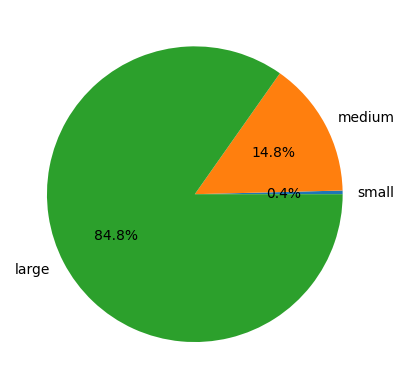

In [10]:
areas_ratio = [x / total_boxes for x in bbox_areas]

plt.pie(areas_ratio, labels=['small', 'medium', 'large'], autopct="%.1f%%")
plt.show()

- YOLO는 이렇고, 현재 가장 좋은 LB 성적을 보이는 csv의 예측 분포는 어떨까?

In [11]:
# ensemble 모델 (lb 0.6573)
# csv load
import pandas as pd

universenet_preds = pd.read_csv("/opt/ml/lb_best.csv")

category_distribution = [0 for _ in range(10)]

no_object_cnt = 0
for preds in universenet_preds['PredictionString']:
    try:
        splitted_preds = preds.split()
    except:
        no_object_cnt += 1
        continue
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])

        category_distribution[category_id] += 1
        
        
print('테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포')
print(category_distribution, 'total : ', sum(category_distribution))
print(no_object_cnt)

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[86889, 69062, 14437, 17533, 12237, 44531, 20134, 61433, 4204, 11146] total :  341606
0


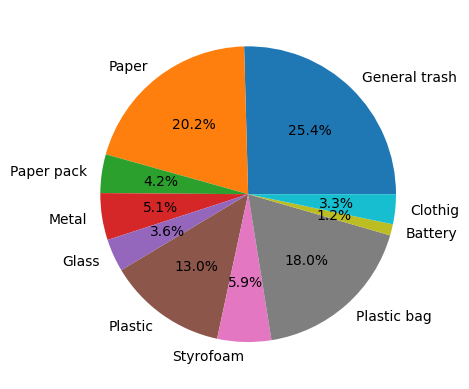

In [12]:
import matplotlib.pyplot as plt

total_boxes = sum(category_distribution)
ratios = [x / total_boxes for x in category_distribution]
labels = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothig']

plt.pie(ratios, labels=labels, autopct="%.1f%%")
plt.show()

- 일반 쓰레기의 비율이 높은 편이다.
- 실제 정답 분포는 알 수 없지만, 적어도 높은 LB score를 기록하기 위해 중요한 요소 중 하나가 일반 쓰레기의 비율이라는 것을 알 수 있다.

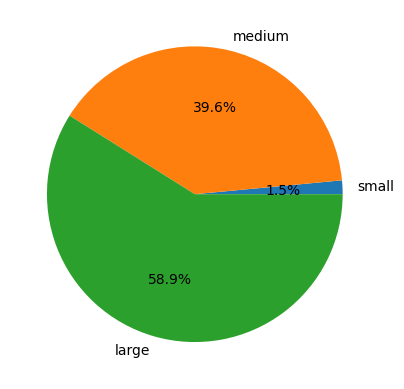

In [15]:
# csv load
import pandas as pd

universenet_preds = pd.read_csv("/opt/ml/lb_best.csv")

bbox_areas = [0 for _ in range(3)] # small, medium, large

no_object_cnt = 0
for preds in universenet_preds['PredictionString']:
    try:
        splitted_preds = preds.split()
    except:
        no_object_cnt += 1
        continue
    
    for idx in range(0, len(splitted_preds), 6):
        category_id = int(splitted_preds[idx])
        confidence_score = float(splitted_preds[idx+1])
        x_min, y_min, x_max, y_max = [float(x) for x in splitted_preds[idx+2:idx+6]]

        bbox_area = (x_max - x_min) * (y_max - y_min) # widht * height = bbox area

        if bbox_area < 32**2: # small bbox
            bbox_areas[0] += 1
        elif bbox_area > 32**2 and bbox_area < 96**2:
            bbox_areas[1] += 1
        elif bbox_area > 96**2:
            bbox_areas[2] += 1

areas_ratio = [x / total_boxes for x in bbox_areas]

plt.pie(areas_ratio, labels=['small', 'medium', 'large'], autopct="%.1f%%")
plt.show()

- medium size의 bbox 분포가 매우 많이 늘어난 모습이다.

- confidence threshold 0.2 기준으로 만들어진 submission.csv를 nms나 wbf하지 않고 단순히 합쳐서 제출해본다면 어떻게 될까?

In [21]:
import pandas as pd

universenet_path = "/opt/ml/UniverseNet/work_dir/dh_lb2_th0.2.csv"
yolov6_path = "/opt/ml/YOLOv6/submission/2023-5-16/yolov6l6_th0.2.csv"

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[10466, 15879, 2039, 2137, 2247, 7196, 2682, 10360, 285, 955] total :  54246
2


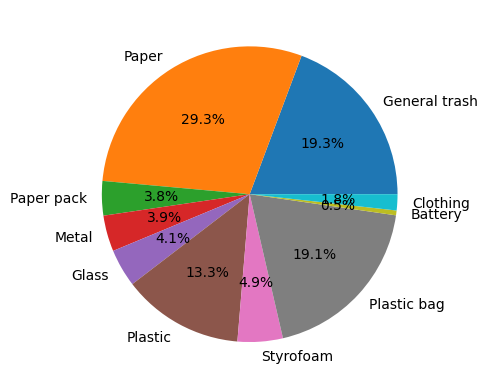

In [22]:
category_distribution(universenet_path)

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[10219, 14128, 1403, 1911, 2140, 7247, 2795, 9150, 224, 849] total :  50066
1


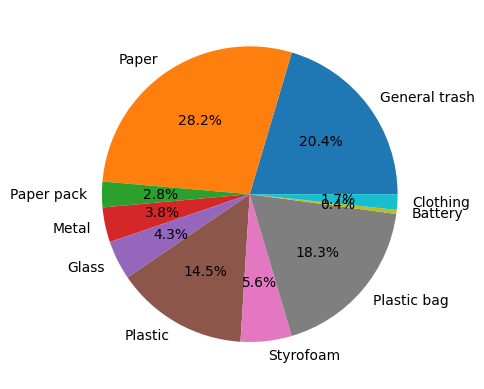

In [23]:
category_distribution(yolov6_path)

In [44]:
universenet_preds = pd.read_csv(universenet_path)
yolov6_preds = pd.read_csv(yolov6_path)

new_submission_df = pd.DataFrame()

new_prediction_strings = []
for universenet_pred, yolov6_pred in zip(universenet_preds['PredictionString'], yolov6_preds['PredictionString']):
    try:
        new_prediction_string = universenet_pred + yolov6_pred
    except:
        new_prediction_string = universenet_pred
    
    new_prediction_strings.append(new_prediction_string)


new_submission_df['PredictionString'] = new_prediction_strings
new_submission_df['image_id'] = universenet_preds['image_id']
new_submission_df.to_csv("/opt/ml/simple_concat_yolov6_universenet_th0.2_submission.csv")

테스트 데이터에 대하여, 모델이 예측한 bbox들의 클래스 분포
[20682, 30006, 3442, 4047, 4387, 14443, 5477, 19510, 509, 1804] total :  104307
2


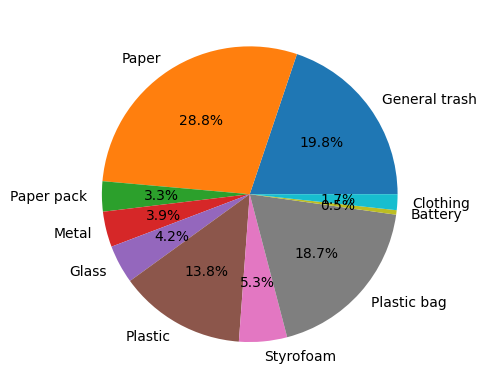

In [45]:
category_distribution("/opt/ml/simple_concat_yolov6_universenet_th0.2_submission.csv")

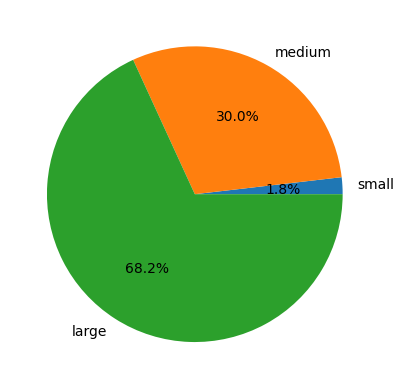

In [46]:
show_bbox_distribution("/opt/ml/simple_concat_yolov6_universenet_th0.2_submission.csv")

- 실제 제출 시 mAP가 대폭 감소했다.
- 실험 목적은 서로 다른 두 모델이 서로 예측하지 못하는 box들을 보완해줄 수 있다면, 단순히 concat하더라도 mAP 스코어는 올라갈 수도 있겠다는 생각을 검증하기 위함이였다.
- 허나 concat해서 제출해본 결과, 실제로는 두 모델 모두 비슷한 예측을 하면서 box의 개수만 늘어났고, 이는 precision이 크게 떨어져 mAP 스코어에 영향을 준 것이라고 생각할 수 있다.